In [1]:
%matplotlib inline

from collections import defaultdict
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import shuffle
from itertools import combinations
from scipy.special import comb

In [2]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False
        for literal in list(literal_clauseNum.keys()):
            if literal in literal_boolen:
                continue

            opposite_literal = switch_literal(literal)
            if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
                # If it doesn't exist or it does but it doesn't have to satisfy any clauses
                if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                    # LITERAL IS A PURE LITERAL
                    keep_updating = True
                    literal_boolen[literal] = True

                    # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                    pairs_to_delete = []
                    for clauseNums_with_literal in literal_clauseNum[literal]:
                        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

            #         print(pairs_to_delete)

                    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                        if clauseNums_with_literal in clauseNum_clause:
                            del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def maxo(literal_clauseNum, return_counts=False):
    """
    Returns the literal that appears in the most number of clauses
    """
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    """
    Returns the literal that appears most in the smallest clauses
    """
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    """
    Combines MAXO and MOMS count statistics from above and chooses the literal that appears most between them
    """
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    """
    Jeroslow-Wang Rule
    """
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

def jw_2(literal_clauseNum, clauseNum_clause):
    """
    2-sided JW rule. See Heutistics folder
    """
    
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in list(literal_score.items()):
        other_literal = switch_literal(literal)
        total_score = score + literal_score[other_literal]
        
        if total_score > max_score:
            max_score = score
            max_lit = literal if score >= literal_score[other_literal] else other_literal
            
    return max_lit, max_score


def bohm(literal_clauseNum, clauseNum_clause):
    """
    See Heuristics folder. Lexicographic order of the vector (H1(x), H2(x), ..., Hn(x)) means we first choose highest H1(x)
    variable. When tied we then choose amongst tied variable highest H2 variable. When tied then H3 and so on.
    
    We've had to manage edge cases here but don't mention that in report. Only give formula from paper
    """
    pos_literal_count = defaultdict(lambda: [0, 0, 0])  # This default initialisation only works for 3 SAT
    neg_literal_count = defaultdict(lambda: [0, 0, 0])
    
    for literal, clauseNums in literal_clauseNum.items():
        if literal.startswith('-'):
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                neg_literal_count[literal][len(clause)-1] += 1
        else:
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                pos_literal_count[literal][len(clause)-1] += 1
                
    final_count = []
    # Sometimes we only have negative literals left. So then we just use those
    for literal, pos_counts in (pos_literal_count.items() or neg_literal_count.items()):
        other_literal = switch_literal(literal)
        
        if literal.startswith('-'):
            # pos_literal_counts is empty. So literal and pos_counts actually are neg_literal_counts
            neg_counts = pos_literal_count[other_literal]
        else:
            # pos_literal_counts isn't empty. So continue as normal
            neg_counts = neg_literal_count[other_literal]
        
        final_count.append(([max(p, n) + 2 * min(p, n) for p, n in zip(pos_counts, neg_counts)], literal))
            
    final_count.sort(reverse=True)
    score_vector, literal = final_count[0]
    other_literal = switch_literal(literal)
    
    if literal.startswith('-'):
        neg_literal = literal
        pos_literal = other_literal
    else:
        neg_literal = other_literal
        pos_literal = literal
    
    # Since the score for positive and negative literal is the same, choose one which the highest overall score
    if sum(pos_literal_count[pos_literal]) >= sum(neg_literal_count[neg_literal]):
        literal = pos_literal
    else:
        literal = neg_literal
    
    return literal, score_vector
    

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw_2':
        literal, _ = jw_2(literal_clauseNum, clauseNum_clause)
    elif algo == 'bohm':
        literal, _ = bohm(literal_clauseNum, clauseNum_clause)
    

    return literal

In [3]:
# Methods that are used by the Env class to get state features

def number_of_variables(literal_clauseNum):
    """ Returns the number of total variables (including repeats) present in the remaining clauses """
    return sum(map(len, literal_clauseNum.values()))


def horn_clause_ratio(clauseNum_clause):
    """ Returns the ratio of horn clauses to total number of clauses """
    horn_count = 0
    total_count = 0
    for clause in clauseNum_clause.values():
        if len(clause) > 0:
            total_count += 1
        if len(list(filter(lambda x: not x.startswith('-'), clause))) == 1:
            horn_count += 1

    return horn_count / total_count if total_count > 0 else 0


def horn_clause_count(literal_clauseNum, clauseNum_clause):
    """
    For each variable, we count the number of Horn clauses it is present in
    """
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            if len(list(filter(lambda x: not x.startswith('-'), clause))) == 1:
                literal_count[literal] += 1
                
    counts = list(literal_count.values())
    return np.array(counts) if len(counts) > 0 else np.array([0])


def clause_to_variable_ratio(literal_clauseNum):
    """ Returns the clause to variable ratio: c/v which predict problem hardness """
    clauses = set()
    num_literals = 0
    for literal, clauseNums in literal_clauseNum.items():
        if len(clauseNums) > 0:
            clauses = clauses.union(clauseNums)
            if literal.startswith('-'):
                num_literals += 1
            else:
                num_literals += 1

    return 0 if num_literals == 0 else len(clauses) / num_literals


def pos_neg_ratio(literal_clauseNum):
    """
    Returns the number of positive literals (incl repeats) to negative literals (incl repeats) in the clauses.
    THIS DOESN'T GIVE USEFUL STATE INFORMATION WHEN USED ALONE
    """
    pos_literal_count = 0
    neg_literal_count = 0

    for literal, clauseNums in literal_clauseNum.items():
        if literal.startswith('-'):
            neg_literal_count += len(clauseNums)
        else:
            pos_literal_count += len(clauseNums)

    return pos_literal_count / neg_literal_count if neg_literal_count > 0 else pos_literal_count

def pos_neg_ratio_per_var():
    pass


def CVIG(literal_clauseNum, clauseNum_clause):
    """
    Caluse-variable incidence graph. We create a bipartite graph (a matrix) with literals in columns and clauses in rows.
    See Features_2 PDF file.
    """
    if len(clauseNum_clause) == 0:
        return 0
    
    literal_index_mapping = {}
    clauseNum_index_mapping = {}
    
    for i, literal in enumerate(literal_clauseNum.keys()):
        literal_index_mapping[literal] = i
        
    for i, clauseNum in enumerate(clauseNum_clause):
        clauseNum_index_mapping[clauseNum] = i
    
    graph = np.zeros((len(literal_index_mapping), len(clauseNum_index_mapping)))
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            graph[literal_index_mapping[literal]] [clauseNum_index_mapping[clauseNum]] = 1/len(clauseNums)
    
    return graph

def VIG(literal_clauseNum, clauseNum_clause):
    """
    Variable incidence graph.
    """
    if len(clauseNum_clause) == 0:
        return 0
    
    literal_index_mapping = {}
    
    for i, literal in enumerate(literal_clauseNum.keys()):
        literal_index_mapping[literal] = i
        
    graph = np.zeros((len(literal_index_mapping), len(literal_index_mapping)))
    
    for clause in clauseNum_clause.values():
        if len(clause) < 2:
            continue
        for x, y in combinations(clause, 2):
            w = 1 / (comb(len(clause), 2))  # Try combinations with replacement to add self-loops
            graph[literal_index_mapping[x]][literal_index_mapping[y]] = w
            graph[literal_index_mapping[y]][literal_index_mapping[x]] = w
            
    return graph

In [4]:
# env = Env('../Tests/SATLIB_20/uf20-026.cnf')
# print(env.reset())
# while True:
#     _, _, done = env.step(4)
#     if done:
#         break
#     print(env.get_state())
# #     a, b, c = env.state
# #     print(jw_2(a, b))

In [5]:
class Env:
    
    def __init__(self, input_file):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
        self.actions = {0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}
        self.action_penalty = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}  # Penalty to give each action
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_var = number_of_variables(literal_clauseNum)
        horn_clause = horn_clause_ratio(clauseNum_clause)

#         var_horn_counts = horn_clause_count(literal_clauseNum, clauseNum_clause)
#         var_horn_mean, var_horn_var = np.mean(var_horn_counts), np.var(var_horn_counts)  # DON'T USE
        
        pn_ratio = pos_neg_ratio(literal_clauseNum)
#         c_v_ratio = clause_to_variable_ratio(literal_clauseNum)
        
        cvig_graph = CVIG(literal_clauseNum, clauseNum_clause)
        cvig_mean, cvig_var = np.mean(cvig_graph), np.var(cvig_graph)  # axis=0 gives more different results if we want this to return vector
        
#         vig_graph = VIG(literal_clauseNum, clauseNum_clause)
#         vig_mean, vig_var = np.mean(vig_graph), np.var(vig_graph)
        
#         return [num_var, c_v_ratio, cvig_mean, cvig_var]
        return [num_var, horn_clause, pn_ratio, cvig_var]
#         return num_var
    
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses_start = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_start += 1
            else:
                # This is reached when we reached an UNSAT state in previous step and popped off another UNSAT from the stack
                isEmpty = len(self.stack) == 0
                if not isEmpty:
                    self.state = self.stack.pop()
                return None, -1 + self.action_penalty[action], isEmpty
        
        literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo=self.actions[action])
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
        # Set new state
        self.state = (literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
        # Add new state to queue
        self.stack.append((literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F))
        
        
        if clauseNum_clause_T == {} or clauseNum_clause_F == {}:  # We have satisfied
#             print("INITIAL")
            return None, 1 + self.action_penalty[action], True
        
        
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return None, -1 + self.action_penalty[action], isEmpty
        
        if clauseNum_clause == {}:
#             print("UNIT PROP")
            return None, 1 + self.action_penalty[action], True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
            
        if clauseNum_clause == {}:
#             print("PLE")
            return None, 1 + self.action_penalty[action], True
        
        num_clauses_end = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_end += 1
        
        if num_clauses_start > 0:
            fraction_of_clauses_removed = (num_clauses_start - num_clauses_end)/num_clauses_start
        else:
            fraction_of_clauses_removed = 0
        
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
                
        return None, -1 + self.action_penalty[action] + fraction_of_clauses_removed, False

In [6]:
import tensorflow as tf
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K

from sklearn.preprocessing import StandardScaler

class Estimator():
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.scaler.fit(self.featurize_state([np.zeros(state_space)]), [np.zeros(state_space)])
        
        self.create_model()
        
        self.model = Model(inputs=self.input, outputs=self.output)
        self.action_index = K.placeholder(dtype=tf.int32, name='action_index')
        self.target = K.placeholder(dtype=tf.float32, name='target')
        
        self.chosen_action_qval = tf.gather(self.output, self.action_index, axis=1)
        self.loss = tf.reduce_mean(tf.squared_difference(self.target, self.chosen_action_qval))
        
        # self.optimiser = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.optimiser = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9, use_nesterov=True)
        self.train_op = self.optimiser.minimize(self.loss)
        
    
    def create_model(self):
        if use_poly:
            STATE_SPACE = state_space * poly_degree
        else:
            STATE_SPACE = state_space
        self.input = Input(shape=(STATE_SPACE,))
        self.h1 = Dense(2, activation='sigmoid')(self.input)
#         self.a1 = LeakyReLU()(self.h1)
#         self.h2 = Dense(2, activation=None)(self.a1)
#         self.a2 = LeakyReLU()(self.h2)
#         self.norm = BatchNormalization()(self.a1)
        self.output = Dense(actions, activation=None)(self.h1)
        
        
    def featurize_state(self, state):
        # State is a batch of states
        if use_poly:
            if type(state) is int:
                return np.array([state**i for i in range(1, poly_degree+1)])
            else:
                poly_batch = []
                for s in state:
                    s = int(s)
                    poly_batch.append([s**i for i in range(1, poly_degree+1)])
                return np.array(poly_batch)
        else:
            return np.array(state)
    
    def predict(self, state):
        state = self.featurize_state(state)
        if len(self.input.shape) != len(state.shape):
            state = np.expand_dims(state, 0)
        state = self.scaler.transform(state)
        return np.squeeze(self.model.predict(state))
    
    def update(self, state, action_index, target):
        """ action: action_index of the literal we chose """
        state = self.featurize_state(state)
        action_index = np.array(action_index)
        target = np.array(target)
        
        sess = tf.get_default_session()
        if len(self.input.shape) != len(state.shape):
            state = np.expand_dims(state, 0)
        if len(action_index.shape) != 2:
            action_index = np.expand_dims(action_index, 0)
        if len(target.shape) != 2:
            target = np.expand_dims(target, 0)
            
        self.scaler.partial_fit(state)
        state = self.scaler.transform(state)
            
        _, loss = sess.run([self.train_op, self.loss], feed_dict={self.input: state, self.action_index: action_index, 
                                                                  self.target: target, K.learning_phase(): 1})
        return loss

/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        if epsilon > np.random.rand():
            return np.ones(nA) / nA
        else:
            action_value = estimator.predict(observation)
            action = np.argmax(action_value)
            ans = np.zeros(nA)
            ans[action] = 1
            return ans

    return policy_fn

In [8]:
import random

def copy_params(copy_from_est, copy_to_est):
    copy_to_est.model.set_weights(copy_from_est.model.get_weights())
    

def DQN(training_files, batch_size=128, discount_factor=1.0, epsilon=0.4, epsilon_decay=0.965):
    
    q_estimator = Estimator()
    target_estimator = Estimator()
    
    replay_memory = []
    rewards_every_1000 = []
    length_every_1000 = []
    loss_every_1000 = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(q_estimator, epsilon, actions)
    
    print("Starting populating memory")
    # Populate memory
    for i, filepath in enumerate(training_files[:1000]):
        
        if i % 100 == 0:
            print('Populating', i)
        
        env = Env(filepath)
        state = env.reset()
        
        
        while True:
            action_probs = policy(state)
            action =  np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            _, reward, done = env.step(action)
            next_state = env.get_state()
            replay_memory.append((state, action, reward, next_state, done))
            if done:
                break
            
            state = next_state
            
            
    # Make target network predict actual discounter total rewards received using MC method
    # We know that the memory recorded is sequential. So we have episodic data
#     states_batch, action_batch, targets_batch = [], [], []
#     curr_episode_rewards = []
#     for state, action, reward, next_state, done in replay_memory:
#         states_batch.append(state)
#         action_batch.append(action)
#         curr_episode_rewards.append(reward)
        
#         if done:
#             # Calculate the targets from the rewards seen in episode
#             ans = list(np.cumsum(curr_episode_rewards[::-1])[::-1])  # Only works since discount factor = 1.0
#             targets_batch.extend(ans)
#             curr_episode_rewards = []
    
#     loss = 500
#     while loss > 200:
#         states_batch, action_batch, targets_batch = np.array(states_batch), np.array(action_batch), np.array(targets_batch)      
#         # Sample some of the data points. Better than giving it new data every time
#         sample_idx = np.array(random.sample(range(len(states_batch)), batch_size))
# #         print(loss, states_batch[sample_idx[0]], action_batch[sample_idx[0]], targets_batch[sample_idx[0]])
#         loss = target_estimator.update(states_batch[sample_idx], action_batch[sample_idx], targets_batch[sample_idx])
        
        
            
    max_memory = len(replay_memory) * 10
    print("Memory size:", max_memory)
    
    print("Starting training")
    
    curr_reward = 0
    curr_length = 0
    curr_loss = 0
    output_stats_every = 1000
    
    for i, filepath in enumerate(training_files[1000:]):
        
        env = Env(filepath)
        state = env.reset()
        
        if i % output_stats_every == 0:
            print(i, curr_reward / output_stats_every, curr_length / output_stats_every, curr_loss / output_stats_every)
            rewards_every_1000.append(curr_reward / output_stats_every)
            length_every_1000.append(curr_length / output_stats_every)
            loss_every_1000.append(curr_loss / output_stats_every)
            
            curr_reward = 0
            curr_length = 0
            curr_loss = 0
            
            # Copy model parameters over
            copy_params(q_estimator, target_estimator)
            
            # Make new policy
            part = i // output_stats_every
            print("New epsilon:", epsilon*(epsilon_decay**part))
            policy = make_epsilon_greedy_policy(q_estimator, epsilon*(epsilon_decay**part), actions)
        
        
        while True:
            action_probs = policy(state)
            action =  np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            _, reward, done = env.step(action)
            
            next_state = env.get_state()
            replay_memory.append((state, action, reward, next_state, done))
            if len(replay_memory) > max_memory:
                replay_memory.pop(0)
                
            # Update stats
            curr_reward += reward
            curr_length += 1
            
            if done:
                break
                
            state = next_state
        
        # Sample a minibatch from the replay memory
        samples = random.sample(replay_memory, batch_size)
        states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
        
        # Calculate q values and targets
        q_values_next = target_estimator.predict(next_states_batch)
        targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)
        
        curr_loss += q_estimator.update(states_batch, action_batch, targets_batch)
        if i % (output_stats_every/10) == 0:
            print(states_batch[0], action_batch[0], targets_batch[0])
        
    rewards_every_1000.append(curr_reward / output_stats_every)
    length_every_1000.append(curr_length / output_stats_every)
    loss_every_1000.append(curr_loss / output_stats_every)    
    
    
    return rewards_every_1000, length_every_1000, loss_every_1000, q_estimator

In [9]:
def test(test_files, ϵ=1.1, estimator=None):
    """
    This method is used to either:
    
     - Run a random policy on the test data and returns the avg. reward and length per epoch (epoch runs over the test_files).
     This can be done by only passing on first two parameters (and optionally epochs for longer runs)
     
     - Run an epilon-greedy policy with the given estimator. Pass an estimator that we receive from the train() method and set 
     the ϵ value appropriately to make an epsilon-greedy policy. Runs this policy over the test_files for given number of epochs.
    
    Returns dictionary of {epoch: average reward} and {epoch: average length per episode/file}
    """
    total_reward, total_length, total_states, total_actions = 0, 0, [], []
    
    if estimator is None:
        estimator = Estimator()  # Never used if epsilon > 1
        
    policy = make_epsilon_greedy_policy(estimator, ϵ, actions)
    
    for i, filepath in enumerate(test_files):
        
        if i % 100 == 0:
            print("Testing file", i)
        
        env = Env(filepath)
        state = env.reset()
        
        while True:
            action_probs = policy(state)
            action =  np.random.choice(np.arange(len(action_probs)), p=action_probs)
            _, reward, done = env.step(action)

            # Stats
            total_length += 1
            total_reward += reward
            total_actions.append(action)

            if done:
                break

            state = env.get_state()

    return total_reward/len(test_files), total_length/len(test_files), np.array(total_actions) #, total_states

In [10]:
sess = tf.InteractiveSession()
tf.global_variables_initializer()

<tf.Operation 'init' type=NoOp>

In [11]:
# %%prun
# import time

use_poly = False  # Set this to True if you want the Estimator to change state to a polynomial. State must be a single number.
poly_degree = 7   # Degree of polynomial is use_poly is set to True
actions = 6       # Number of actions available to use by the agent
state_space = 4   # Number of variables we return as state of environment. Used to initialise Scaler and SGD in Estimator

directory = '../Tests/CNFGEN_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))
# shuffle(files)

split = int(len(files) * 0.3)
training_files = files[:split]
test_files = files[60000:61000]

# directory = '../Tests/SATLIB_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
# files = os.listdir(directory)
# files = list(map(lambda x: os.path.join(directory, x), files))
# split = int(len(files) * 1.0)
# test_files = files[split:split+int(len(files) * 0.01)] 


print("Number of training files:", len(training_files))
print("Number of test files:", len(test_files))

    
s = time.time()
episode_reward_train, episode_length_train, losses, estimator = DQN(training_files, epsilon=0.8, epsilon_decay=0.92)
#     episode_reward_train_2, episode_length_train_2, estimator_2, losses = train(training_files, epochs=1, ϵ=0.3, epsilon_decay=0.95)
#     episode_reward_train_3, episode_length_train_3, estimator_3, losses = train(training_files, epochs=1, ϵ=0.3, epsilon_decay=0.95)
e = time.time()
print("Done training in", (round(e-s, 2)), "s")
print()

est = estimator

s = time.time()
episode_reward_test, episode_length_test, episode_actions = test(test_files, ϵ=0, estimator=est)
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))

#     est=estimator_2
#     episode_reward_test, episode_length_test, episode_actions = test(test_files, epochs=1, ϵ=0.1, estimator=est)
#     print(episode_reward_test, episode_length_test)

e = time.time()
print("Done testing in", (round(e-s, 2)), "s")
print()

#     counts = policy_use(np.array(states), est, 50000)
#     print(counts)

#     print(np.bincount(episode_actions))

s = time.time()
episode_reward_rand, episode_length_rand, episode_actions_rand = test(test_files)
print(np.bincount(episode_actions_rand))
print(episode_reward_rand, episode_length_rand)
e = time.time()
print("Done testing random policy in ", (round(e-s, 2)), "s")
print()

Number of training files: 30000
Number of test files: 1000
Starting populating memory
Populating 0
Populating 100
Populating 200
Populating 300
Populating 400
Populating 500
Populating 600
Populating 700
Populating 800
Populating 900
Memory size: 207780
Starting training
0 0.0 0.0 0.0
New epsilon: 0.8
[8.20000000e+01 2.36842105e-01 1.00000000e+00 4.83985457e-03] 0 -0.9968272871337831
[1.63000000e+02 3.49206349e-01 1.01234568e+00 2.67485571e-03] 0 -0.9999879781044001
[1.77000000e+02 4.17910448e-01 1.05813953e+00 2.84941060e-03] 0 -0.9999999812328699
[1.75000000e+02 5.15625000e-01 9.66292135e-01 3.15105135e-03] 0 -0.999996083483893
[3.10000000e+01 4.76190476e-01 6.31578947e-01 9.31129477e-03] 3 -0.9997644539107569
[8.         0.25       0.6        0.02984375] 2 1.0
[1.93000000e+02 3.14285714e-01 1.14444444e+00 2.45727888e-03] 4 -0.9999999915083375
[2.06000000e+02 3.94736842e-01 9.61904762e-01 2.24763526e-03] 0 -0.9999987731583815
[1.82000000e+02 4.70588235e-01 1.09195402e+00 2.58490896e-

KeyboardInterrupt: 

In [12]:
# %debug

sess.close()

In [62]:
for l in est.model.layers:
    print(l.get_weights())

# est.model.get_weights()

[]
[array([[ 0.5533465 ,  0.79572165],
       [-0.23814051, -0.29424837],
       [-0.7888638 , -1.0185864 ],
       [-0.45048192, -0.40047312]], dtype=float32), array([0.01703539, 0.02398902], dtype=float32)]
[]
[array([0.33113232, 0.00962237], dtype=float32), array([ 0.0695339, -2.3588939], dtype=float32), array([0., 0.], dtype=float32), array([1., 1.], dtype=float32)]
[array([[-0.08477044, -0.07827584, -0.08798654, -0.08244146, -0.09258121,
        -0.06924793],
       [ 2.9100208 ,  2.6903949 ,  3.0221245 ,  2.833358  ,  3.1678076 ,
         2.3839467 ]], dtype=float32), array([-3.0617092, -3.5869508, -2.778461 , -3.1824777, -2.6311812,
       -3.928702 ], dtype=float32)]


In [123]:
# with open('CNFGEN_20_NL_top4_2LR.pickle', 'rb') as fin:
#     episode_reward_train, episode_length_train, losses, episode_reward_test, episode_length_test, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand = pickle.load(fin)

with open('CNFGEN_20_NL_top4_4SigNorm2SigNorm.pickle', 'rb') as fin:
    episode_reward_train, episode_length_train, losses, episode_reward_test, episode_length_test, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand = pickle.load(fin)

In [124]:
print("Learnt policy")
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))
print()
print("Random policy")
print(np.bincount(episode_actions_rand))
print(episode_reward_rand, episode_length_rand)

Learnt policy
-10.791406900717902 12.813
[    0     0     0     0     0 12813]

Random policy
[3217 3138 3276 3175 3280 3133]
-16.96771590008879 19.219


In [127]:
from matplotlib2tikz import save as tikz_save

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Average reward for last 5 epochs in training: -11.285


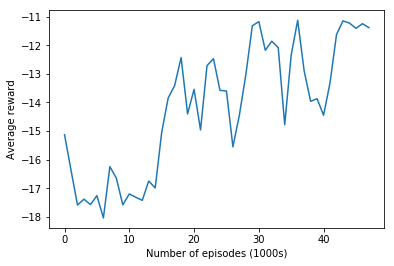

In [128]:
time_taken_avg = np.array(episode_reward_train)
# time_taken_avg_2 = np.array(episode_reward_train_2)
# time_taken_avg_3 = np.array(episode_reward_train_3)

# avgs = np.array([time_taken_avg, time_taken_avg_2, time_taken_avg_3])
# avgs = np.mean(avgs, axis=0)
avgs = time_taken_avg

plt.plot(avgs[1:], label='Training')
# plt.plot(time_taken_avg[1:], label='Run 1')
# plt.plot(time_taken_avg_2[1:], label='Run 2')
# plt.plot(time_taken_avg_3[1:], label='Run 3')
# plt.legend()
# plt.ylim(7, 11)

# print(np.max(avgs[1:]))
# print(np.max(episode_reward_train[1:]), np.max(episode_reward_train_2[1:]), np.max(episode_reward_train_3[1:]))

plt.xlabel("Number of episodes (1000s)")
plt.ylabel("Average reward")


tikz_save('dqn_rewards.tikz', figureheight='\\figureheight', figurewidth='\\figurewidth')

# plt.plot(episode_reward_train[1:], label='Training')
# plt.plot(episode_reward_train_2[1:], label='Training_4')
# plt.plot(episode_reward_test, label='Testing')
# plt.plot(episode_reward_rand, label='Testing rand')

# plt.xlabel('Epoch number')
# plt.ylabel('Average reward per epoch')
# plt.xticks([0, 5, 10, 15, 20])
# plt.xlim(-1, 21)
# plt.legend()

last_n = 5
train_avg = np.mean(np.array(episode_reward_train)[-last_n:])
# test_avg = np.mean(np.array(episode_reward_test)[-last_n:])
# rand_avg = np.mean(np.array(episode_reward_rand)[-last_n:])

print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))
# print("Average reward for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average reward for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Average length for last 5 epochs in training: 13.347


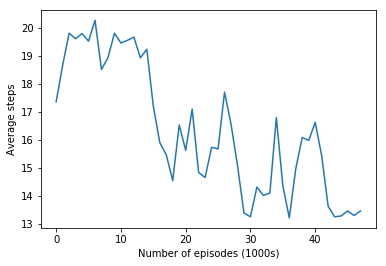

In [133]:
# time_taken_avg = np.array(episode_length_train)
# time_taken_avg_2 = np.array(episode_length_train_2)
# time_taken_avg_3 = np.array(episode_length_train_3)

# avgs = np.array([time_taken_avg, time_taken_avg_2, time_taken_avg_3])
# avgs = np.mean(avgs, axis=0)


# plt.plot(avgs[1:], label='Training')
# plt.plot(time_taken_avg[1:], label='Run 1')
# plt.plot(time_taken_avg_2[1:], label='Run 2')
# plt.plot(time_taken_avg_3[1:], label='Run 3')
# plt.legend()

# print(np.min(avgs[1:]))

# plt.xlabel("Number of episodes (1000s)")
# plt.ylabel("Average steps")
# # plt.ylim(8, 11)

plt.plot(episode_length_train[1:], label='Training')
# plt.plot(episode_length_train_2[1:], label='Training_4')
# plt.plot(episode_length_test, label='Testing')
# plt.plot(episode_length_rand, label='Testing rand')

plt.xlabel("Number of episodes (1000s)")
plt.ylabel("Average steps")
# plt.xticks([0, 5, 10, 15, 20])
# plt.xlim(-1, 21)
# plt.legend()

tikz_save('dqn_length.tikz', figureheight='\\figureheight', figurewidth='\\figurewidth')

train_avg = np.mean(np.array(episode_length_train)[-last_n:])
# test_avg = np.mean(np.array(episode_length_test)[-last_n:])
# rand_avg = np.mean(np.array(episode_length_rand)[-last_n:])

print("Average length for last", last_n, "epochs in training:", round(train_avg, 3))
# print("Average length for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average length for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


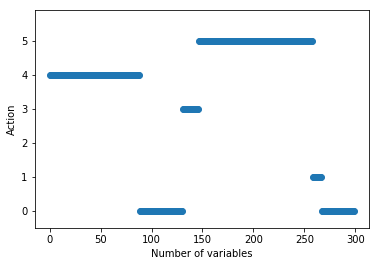

In [12]:
xs = range(300)


policy = make_epsilon_greedy_policy(estimator, 0, actions)
ys = [np.random.choice(np.arange(actions), p=policy(i)) for i in xs]

plt.scatter(xs, ys)
plt.xlabel("Number of variables")
plt.ylabel("Action")
plt.ylim(-0.5, 5.9)

# tikz_save('td_actions_3.tikz', figureheight='\\figureheight', figurewidth='\\figurewidth')

In [64]:
state = [152, 4.2, 0.009, 0.004]

est.predict(state)

array([ -9.943104,  -9.949048,  -9.924979,  -9.882643, -10.121991,
        -9.566195], dtype=float32)

Text(0,0.5,'Q-value')

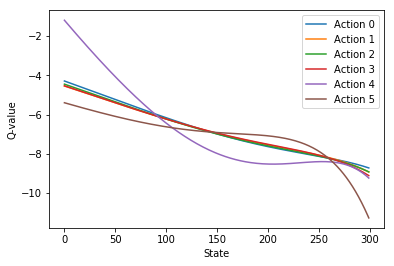

In [13]:
# plt.figure(figsize=(10, 12))

q_values = np.array([estimator.predict(s) for s in xs])

for i in range(actions):
    plt.plot(q_values[:, i], label='Action '+str(i))

plt.legend()
plt.xlabel('State')
plt.ylabel('Q-value')

Testing time taken to use a heuristic

In [88]:
import time

heuristic = jw_2
directory = '../Tests/SATLIB_20/'
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))

split = int(len(files) * 0.1)
training_files = files[:split]

total_time = 0

for file in training_files:
    env = Env(file)
    env.reset()
    a, b, c = env.state
    
    s = time.time()
    for _ in range(1000):
        heuristic(a, b)
    e = time.time()
    total_time += (e - s) / 1000
    
print(total_time / split)

0.00011689195871353151


In [ ]:
{0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}